In [1]:
%pylab notebook
import random as rd
from neuron import h , gui
from neuron.units import ms , mV
import matplotlib.pyplot as plt
import numpy as np
import os
# import pandas as pd
# import feather
import math
from scipy.signal import butter, lfilter, freqz, filtfilt, periodogram
h.load_file('stdrun.hoc')

Populating the interactive namespace from numpy and matplotlib


1.0

# Parâmetros 
parametros extracell do \cite{Appukutan2017}
o sigma do LFP foi com base no ELFENN \cite{Shiffman2019}
os parameros de posição de LFP e tamanho das celulas n temos referencias 

In [2]:
#####################
# PARAMETRO MAIS IMPORTANTE DO SISTEMA : numero de celulas = ncell**2
ncell = 13
celldist = 30 #um
######################

#### tamanhos das celulas
diam_soma = 20 #um
L_dend = 100 #um
diam_dend = 5 #um

#### biofisica da celula
R_a = 183 #Ohm * cm

#### extracell
sigma = 0.5#S/m 

r_axial_extracell = [0, 10**9] #MOhm/cm o primeiro termo é zero pois vai ser definido a posteriori
g_extracell = [10**(-9), 10**9] #S/cm2 # verificar xg[0]
c_extracell = [0, 0] #uF/cm2
e_extracell = 0 #mV

xraxial_soma = 4*10**(-6)/(sigma*10**(-2)*h.PI*((diam_soma*10**(-4))**2)) 
xraxail_dend = 4*10**(-6)/(sigma*10**(-2)*h.PI*((diam_dend*10**(-4))**2)) 
g_eph_soma = ( 2*sigma*(10**(-2))/(diam_soma*(10**(-4))*math.log(celldist/diam_soma)) )/( 4+4*(2**(1/2)) )
g_eph_dend = ( 2*sigma*(10**(-2))/(diam_dend*(10**(-4))*math.log(celldist/diam_dend)) )/( 4+4*(2**(1/2)) )

#### sinapses Exp2Sim - subida continua e expoencial e decaimento exponencial
syn_prob = 0.3 # values between (0,1]
percentage_inhneurons = 0.2

syn_tau1_exc = 5 #ms
syn_tau2_exc = 10 #ms
syn_exc = 0 #mV
netcon_weight_exc = 0.002#eso sinaptico, entra na equação da condutividade
netcon_delay_exc = 10 * ms #tempo entre o estimulo e a sinapse
netcon_threshold_exc = -20 #mV 

syn_tau1_inh = 5 #ms
syn_tau2_inh = 10 #ms
syn_inh = -70 #ms
netcon_weight_inh = 0.002#peso sinaptico, entra na equação da condutividade
netcon_delay_inh = 10 * ms #tempo entre o estimulo e a sinapse
netcon_threshold_inh = -20 #mV 

#### estumulação
stim_interval = 100 #120 
stim_tau1 = 5 #ms
stim_tau2 = 10 #ms
stim_e = 0 #mV
stim_weight = 0.003 #peso sinaptico, entra na equação da condutividade #minimo = 0.004
stim_delay = 0 * ms #tempo entre o estimulo e a sinapse
stim_threshold = -20 #mV 
stim_poisson = 1 #1: poisson spikes, 0: deterministic

stim_iclamp_dur = 5*ms
stim_iclamp_amp = 0.47#.187#nA
stim_sinclamp_freq = 20 #Hz

#### parametros LFP
xLFP = 10 #posição no eixo x do eletrodo do LFP em um
yLFP = 60 #posição no eixo y do eletrodo do LFP em um
zLFP = 75 #posição no eixo z do eletrodo do LFP em um

#### frequencia de amostragem - sample fequency
fs = 40000 #Hz

#### simulation duration 
sim_dur = 2500 #ms
#### initial condition of intracellular electric potential
v_inicial = -68 #mV
#### number of seeds
nseeds = 10
#### number of neighbors
neigh = 6
ncell = 1+2*(2+neigh)
conductivities = [0.1, 0.5, 2.5]

In [3]:
class Cell:
    def __init__(self, index, x, y, z):
        self.index = index
        self._morphology()
        self.all = self.soma.wholetree() #Can be soma.wholetree() ou dend.wholetree()
        self._biophysics()
        self.x = self.y = self.z = 0
        h.define_shape()
        self._set_position(x, y, z)
        
    def _set_position(self, x, y, z):
        for section in self.all: #selecting each section of the tree (soma, dends, axon)
            for isegment in range(section.n3d()): 
                section.pt3dchange(isegment,
                                   x + self.x + section.x3d(isegment),
                                   y + self.y,# + section.y3d(isegment),
                                   z + self.z, #+ section.z3d(isegment),
                                   section.diam3d(isegment))
            self.x, self.y, self.z = x, y, z

class ToyCell(Cell):
    """Cria celula com um soma e um dendrito com um segmento cada
    Os parametros usados aqui estão na celula de parametros"""
    def _morphology(self):
        self.soma = h.Section(name="soma")
        self.dend = h.Section(name="dend")
        
        self.soma.connect(self.dend)
        
        # lenght of cell parts
        self.soma.L = self.soma.diam = diam_soma #micrometers
        self.dend.L = L_dend # micrometers
        self.dend.diam = diam_dend

    def _biophysics(self):
        #active mechanisms 
        self.soma.insert('hh')
#         for segSoma in self.soma:
#             segSoma.hh.el = -60
#             segSoma.hh.gnabar = 0.2
#             segSoma.hh.gkbar = 0.001
        
        #passive mechanisms
        self.dend.insert('pas')
#             for segPassivos in passivos:
#                 segPassivos.pas.e = -70 #de que ion é esse potencial reverso
#                 segPassivos.pas.g = 0.01 # na real issos são listas

        #insert extracellular mechanhisms
        for sec in self.all:
            sec.insert('extracellular')
            for segmento in sec:
                segmento.xraxial[1] = r_axial_extracell[1] 
                segmento.xg[1] = g_extracell[1]
                segmento.xc[0] = c_extracell[0]
                segmento.xc[1] = c_extracell[1]
                segmento.extracellular.e = e_extracell                
            sec.Ra = R_a
            
        for seg_soma in self.soma:
            seg_soma.xraxial[0] = xraxial_soma
            if (self.index['i'] == 0 and self.index['j'] == 0) or (self.index['i'] == ncell-1 and self.index['j'] == ncell-1) or (self.index['i'] == 0 and self.index['j'] == ncell-1) or (self.index['i'] == ncell-1 and self.index['j'] == 0):  
                seg_soma.xg[0] = (2+3*(2**(1/2)))*g_eph_soma               
            elif self.index['i'] == 0 or self.index['j'] == 0 or self.index['i'] == ncell-1 or self.index['j'] == ncell-1:
                seg_soma.xg[0] = (1+2*(2**(1/2)))*g_eph_soma
            else:
                seg_soma.xg[0] = g_extracell[0] ## não borda == infinitesimal

        for seg_dend in self.dend:
            seg_dend.xraxial[0] = xraxail_dend
            if (self.index['i'] == 0 and self.index['j'] == 0) or (self.index['i'] == ncell-1 and self.index['j'] == ncell-1) or (self.index['i'] == 0 and self.index['j'] == ncell-1) or (self.index['i'] == ncell-1 and self.index['j'] == 0):  
                seg_dend.xg[0] = (2+3*(2**(1/2)))*g_eph_dend               
            elif self.index['i'] == 0 or self.index['j'] == 0 or self.index['i'] == ncell-1 or self.index['j'] == ncell-1:
                seg_dend.xg[0] = (1+2*(2**(1/2)))*g_eph_dend
            else:
                seg_dend.xg[0] = g_extracell[0] ## não borda == infinitesimal
            
class LFP():
    """x, y, z é o local de amostra do lfp, cells é o conjunto de celulas, e precisa-se tb passar os dados 
    da evolução das correntes da simulação"""
    def __init__(self, x, y, z, cells, corrente_soma, corrente_dend, corrente_syn, alvo_syn, fs):
        self.local_de_amostra = np.array([x, y, z])
        self.cells = cells #matriz de celulas do abjeto criado acima
        self.i_transmembrane(corrente_soma, corrente_dend)
        self.calcular_V_mem()
        self.i_synapses(corrente_syn, alvo_syn)
        self.filtro_lowpass(fs)
        
    def i_transmembrane(self, corrente_soma, corrente_dend):
        """pegar o posicionamento das celulas e posiscionar as correntes no espaço
        cria um dicionario pra agruapar posição e corrente
        UNIDADES: i_membrane = mA/cm**2 || x,y,z = um"""
        self.I = []
        for m, linha_celulas in enumerate(self.cells):
            for n, item_celula in enumerate(linha_celulas):
                self.I.append({'pos': np.array([0, item_celula.y, item_celula.z]), 
                              'corrente_soma': corrente_soma[m][n],
                              'corrente_dend': corrente_dend[m][n]}) 
    
    def calcular_V_mem(self):
        """imprementar a equação V = (I*r/(2 sigma)) * log|sqrt(h^2+r^2)-h / sqrt(l^2+r^2)-l)|
        l é a distância do ponto inicial da section ate o ponto da medida
        h é a distância do ponto final da section ate o ponto da medida
        r é o raio da seção"""
        self.pot_cell = []
        for i in self.I:
            l_soma = ((i['pos'] - self.local_de_amostra)**2).sum()**0.5
            i['pos'][0] = i['pos'][0] + self.cells[0][0].soma.L
            h_soma = ((i['pos'] - self.local_de_amostra)**2).sum()**0.5
            
            l_dend = ((i['pos'] - self.local_de_amostra)**2).sum()**0.5
            i['pos'][0] = i['pos'][0] + self.cells[0][0].dend.L
            h_dend = ((i['pos'] - self.local_de_amostra)**2).sum()**0.5
            
            # o fator (10**(-2)) é utilizado para a unidade de Vout seja mV,
            # é um fator para corrigir as unidades de comprimento e-6/e-4
            # i é em nA talvez precise consertar isso
            Vout_soma = ((i['corrente_soma']*(diam_soma*10**(-4)/2))/(2*sigma*10**(-2)))*math.log(((h_soma**2+(diam_soma/2)**2)**0.5-h_soma)/((l_soma**2+(diam_soma/2)**2)**0.5-l_soma))
            Vout_dend = ((i['corrente_dend']*(diam_dend*10**(-4)/2))/(2*sigma*10**(-2)))*math.log(((h_dend**2+(diam_dend/2)**2)**0.5-h_dend)/((l_dend**2+(diam_dend/2)**2)**0.5-l_dend)) 

            self.pot_cell.append(Vout_soma + Vout_dend)
        
        self.V_mem = np.zeros(len(self.pot_cell[0]))
        for potenciais in self.pot_cell:    
            self.V_mem += potenciais

    def i_synapses(self, corrente_syn, alvo_syn): # a corr_syn é em nA e a imembrane é mA/cm2
        """computa a coontribuição da corrente sinaptica para o calculo do LFP
        utilizarei a formula V = i / (4 pi sigma R) 
        em que R é a distancia do ponto de saida da corrente ate o eletrodo
        UNIDADES: i_syn = nA || sigma = S/m || R = um
        
        Notemos que o termo é -syn_i pq essa corrente que foi armazenada na variavel estaria entrando na celula
        Isso significa que para o meio extracelular há saida de ions
        Também vale lebrar que nesse caso o sistema de referencias é dado por todas as correntes que entram
        no meio extacelular são positivas. Nesse caso como ha passagem de corrente extracelular para o
        intracelular a corrente é utilizado com o sinal negativo"""
        self.V_syn = 0 
        for syn_i, trgt in zip(corrente_syn, alvo_syn):
            syn_i = syn_i*10**(-6)#transforma de nA para mA
            r_syn = np.linalg.norm(np.array([trgt.x,trgt.y,trgt.z])-self.local_de_amostra)
            self.V_syn += -syn_i /(4*h.PI*sigma*r_syn*10**(-6))
        self.LFP = self.V_mem + self.V_syn        

    def filtro_lowpass(self, fs):
        cutoff = 200 #hz
        order = 6
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        self.filt_LFP = lfilter(b, a, self.LFP)

# Funções do programa

In [4]:
def create_InhNeurons(cells):
    """ EN - In this functions it will be selected which neurons would be inhibitory. It will be used 
    the proportion of 20% inhibitory for 80% exitatory.
    PT - nessa função vamos definir que neuronios serão inibitorios. Para isso utilizaremos a proporção
    de 20% inibitórios para 80% excitatorios"""
    inh_cell = []
    ntotalcell = ncell**2
    # len(inh_cell) <= ntotalcell*0.2
    while len(inh_cell) < ntotalcell*percentage_inhneurons:
        rd_line = rd.choice(cells)
        rd_neuron = rd.choice(rd_line)
        if not(rd_neuron in inh_cell): 
            inh_cell.append(rd_neuron)
    return inh_cell   

def syn_connection(celulas, inh_cell): 
    """
    EN - Given a matrix of cells, it conects all cells that are first neighbours from each other. 
    It has been used duble exponential synapse. Connection will be done if, given a cell[i][j] and cell[m][n]
    i - m <= 1 & j - n <= 1, connecting neighbours in the diagonal, vertical and horizontal. 
    The probability of a synapse to be done is determined by syn_prob.
    PT - Dada uma lista de celulas queremos fazer uma conexão sinaptica entre a celula proximas.
    Utilizaremos sinapses exponencias duplas. 
    A probabilidade de uma sinapse ser feita é indicada pela variavel syn_prob.
    """
    netcons, syns, target = [], [], []
    for (i, linCel1) in enumerate(celulas):
        for (j, sourceCell) in enumerate(linCel1):
            for (m, linCel2) in enumerate(celulas):
                for (n, targetCell) in enumerate(linCel2):
                    if sourceCell.index != targetCell.index:  
                        trgt = celulas[m][n] #I do this beacuse NEURON have some bugs
                        syn = h.Exp2Syn(trgt.dend(0.5))#1
                        nc = h.NetCon(celulas[i][j].soma(0.5)._ref_v, syn, sec = celulas[i][j].soma) 
                        if (sourceCell in inh_cell) and not(targetCell in inh_cell): #inh>>exc
                            nc.weight[0] = netcon_weight_inh
                            syn.tau1 = syn_tau1_inh
                            syn.tau2 = syn_tau2_inh
                            syn.e = syn_inh
                            nc.delay = netcon_delay_inh #ms
                            nc.threshold = netcon_threshold_inh #mV
                        elif not(sourceCell in inh_cell) and not(targetCell in inh_cell): #exc>>exc
                            nc.weight[0] = netcon_weight_exc 
                            syn.tau1 = syn_tau1_exc
                            syn.tau2 = syn_tau2_exc
                            syn.e = syn_exc
                            nc.delay = netcon_delay_exc #ms
                            nc.threshold = netcon_threshold_exc #mV
                        elif not(sourceCell in inh_cell) and (targetCell in inh_cell): #exc>>inh 
                            nc.weight[0] = netcon_weight_exc 
                            syn.tau1 = syn_tau1_exc
                            syn.tau2 = syn_tau2_exc
                            syn.e = syn_exc
                            nc.delay = netcon_delay_exc #ms
                            nc.threshold = netcon_threshold_exc #mV
                        else: #inh>>inh There is no connection
                            nc.weight[0] = 0
                        netcons.append(nc)
                        syns.append(syn) 
                        trgt.x = trgt.soma.L + trgt.dend.L
                        target.append(trgt)
    total_syns = 10*(ncell**2)*syn_prob #each cell will have aprox 10 syynapses
    while len(syns) > total_syns:
        indexx = rd.randint(0,len(syns)-1)
        exclude_target = target[:]
        del exclude_target[indexx]
        if target[indexx] in exclude_target:
            del target[indexx]            
            del syns[indexx]  
            del netcons[indexx]
        #### I do this because there is certanty in the numbre of synapses beeing done.
    return netcons, syns, target #target in here is used to calculate LFP in the LFP class


def criar_celulas(N):
    """cria o numero do argumento de celulas numa malha quadrada, como se colocasse peças no xadrez
    o tamanho vai ser NxN dando N^2 celulas no total"""
    cellmatrix = []
    cellline = []
    for i in range(N):
        for j in range(N):
            cellline.append(ToyCell({'i':i ,'j':j},0, i * celldist, j * celldist))
        cellmatrix.append(cellline)
        cellline = []
    return cellmatrix

def symmetrize(a):
    """
    Return a symmetrized version of NumPy array a.

    Values 0 are replaced by the array value at the symmetric
    position (with respect to the diagonal), i.e. if a_ij = 0,
    then the returned array a' is such that a'_ij = a_ji.

    Diagonal values are left untouched.

    a -- square NumPy array, such that a_ij = 0 or a_ji = 0, 
    for i != j.
    """
    return a + a.T - np.diag(a.diagonal())

def testeDoOffsetSendoNseg(nseg, ncell, i, col, lin):
    """Testa se o valor da casela da matriz tem que ser zero
    para o offset == nseg e para offset == ncell*nseg+nseg"""
    for lin in lin:
        if i == nseg* (col+lin + (ncell-1)*lin) or i == nseg* (col+lin + (ncell-1)*lin) + 1:
            return True 
    return False
        
def testeDoOffsetDoNegativo(nseg, ncell, i, lin):
    """Testa se o valor da casela da matriz tem que ser zero
    para o offset == ncell*nseg-nseg"""
    for lin in lin:
        if i == nseg* ncell*lin or i == nseg* ncell *lin + 1:
            return True 
    return False

def extracellular_link(celulas, qtdcell):
    """
    Cria um unico linear mech pra todo o tecido, criando o meio extracelular continuo para o ncell>2
    Funciona bem para celulas com 2 seçoes e nseg == 1 em cada uma delas
    """
    nseg = 0
    for sec in celulas[0][0].all:
        nseg += sec.nseg
    g_e_soma = g_eph_soma
    g_e_dend = g_eph_dend
    
    tam = nseg * (qtdcell**2)  #tamanho dos vetores
    c = h.Matrix(tam, tam) #(nroll,ncoll)
    g = h.Matrix(tam, tam)
    y = h.Vector(tam) #(lengnth) esse aqui diz sobre uma corrente externa aplicada
    b = h.Vector(tam)
    sl = h.SectionList()
    xvec = h.Vector(tam)
    layervec = h.Vector(tam)
                
    condutancias = np.zeros((tam,tam))
    col = np.arange(ncell)
    lin = np.arange(ncell)
    for offset in range(tam): #percorre as diagonais
        if offset == nseg: #testa pra ver se é uma diagonal que vai se != 0 
            for i in range(tam-offset): #pega o restante das colunas que falta dado o offset
                if testeDoOffsetSendoNseg(nseg, ncell, i, col[(ncell-1)], lin[:(ncell-1)]):
                    condutancias[i][i+offset] = 0
                else:
                    if i%2 != 0: #linha referente ao soma
                        condutancias[i][i+offset] = -g_e_soma
                    else: #linha referente ao dend
                        condutancias[i][i+offset] = -g_e_dend
        elif offset == (qtdcell * nseg) - nseg:
            for i in range(tam-offset):
                if testeDoOffsetDoNegativo(nseg, ncell, i, lin):
                    condutancias[i][i+offset] = 0
                else:
                    if i%2 != 0: 
                        condutancias[i][i+offset] = -g_e_soma/math.sqrt(2)
                    else: 
                        condutancias[i][i+offset] = -g_e_dend/math.sqrt(2)
        elif offset == qtdcell * nseg:
            for i in range(tam-offset):
                if i%2 != 0: 
                    condutancias[i][i+offset] = -g_e_soma
                else: 
                    condutancias[i][i+offset] = -g_e_dend
        elif offset == (qtdcell * nseg) + nseg :   
            for i in range(tam-offset):
                if testeDoOffsetSendoNseg(nseg, ncell, i, col[(ncell-1)], lin[:(ncell-1)]):
                    condutancias[i][i+offset] = 0
                else:
                    if i%2 != 0:
                        condutancias[i][i+offset] = -g_e_soma/math.sqrt(2)
                    else: 
                        condutancias[i][i+offset] = -g_e_dend/math.sqrt(2)
    condutancias = symmetrize(condutancias) #simetrize the matrix
    for i in range(tam): #buids up the matriz diagonal summing the condoctances of the line
        condutancias[i][i] = (-1)*np.sum(condutancias[i])
    for (indiceLinha, linha) in enumerate(condutancias): #transforma matriz do numpy para o hoc
        for (indiceCol, item) in enumerate(linha):
            g.setval(indiceLinha,indiceCol,item)
    
    #for k in range(neg):  dai n muda tb o que ta escrito embaixo, caso trabalhemos com celulas com >1 seg
    for i in range(ncell):
        for j in range(ncell):
            for sec in celulas[i][j].all:
                sl.append(sec)
    for i in range(tam):
        xvec[i] = 0.50

    #seting to get the first layer of the extracellular medium. Zero would be the intracellular potential
    layervec.fill(1)
    
    return  c, g, y, b, sl, xvec, layervec

def random_stimulation():
    """ EN- allocates one random stimulation at each neuron of the network. 
    HYPOTHESIS: all neurons are reciving aleatory spikes from other cortex cells 
    PT- coloca uma(1) estimulação com entrada aleatoria em cada neuronio da rede
    HIPOTESE: todos os neuronios estão sofrendo spikes de outras celulas do cortex."""
    stimulators = []
    syns_ = []
    ncstims = []
    for (i, linhaCel) in enumerate(celulas):
        for (j, ____) in enumerate(linhaCel):
            stimulator = h.NetStim() # Make a new stimulator            
            stimulator.number = 100000 #number of spikes
            stimulator.start = stim_interval*np.random.rand()* ms #NetStim will start at t=0
            stimulator.interval = stim_interval*np.random.rand()* ms
            stimulator.noise = 1 # 1 -> poisson spikes
            syn_ = h.Exp2Syn(celulas[i][j].dend(1)) #synapse with continous conductance
            syn_.tau1 = stim_tau1 #ms
            syn_.tau2 = stim_tau2 #ms
            syn_.e = stim_e
            ncstim = h.NetCon(stimulator, syn_)
            ncstim.delay = stim_delay *np.random.rand()#ms
            ncstim.weight[0] = stim_weight
            ncstim.threshold = stim_threshold #mV
            
            stimulators.append(stimulator)
            syns_.append(syn_)
            ncstims.append(ncstim)
    return stimulators, syns_, ncstims

# Testing Functions

In [5]:
def syn_connection_notCentral(celulas, inh_cell): 
    """
    EN - Given a matrix of cells, it conects all cells that are first neighbours from each other. 
    It has been used duble exponential synapse. Connection will be done if, given a cell[i][j] and cell[m][n]
    i - m <= 1 & j - n <= 1, connecting neighbours in the diagonal, vertical and horizontal. 
    The probability of a synapse to be done is determined by syn_prob.
    PT - Dada uma lista de celulas queremos fazer uma conexão sinaptica entre a celula proximas.
    Utilizaremos sinapses exponencias duplas. A conexão acontece se a celula for a primeira vizinha de outra
    Assim i - m <= 1 & j - n <= 1, temos que conectaremos as vizinhas nas diagonais e na vertical e horizontal.
    A probabilidade de uma sinapse ser feita é indicada pela variavel syn_prob.
    """
    netcons, syns, target = [], [], []
    for (i, linCel1) in enumerate(celulas):
        for (j, sourceCell) in enumerate(linCel1):
            for (m, linCel2) in enumerate(celulas):
                for (n, targetCell) in enumerate(linCel2):
                    if sourceCell.index != targetCell.index and abs(i - m) <= 1 and abs(j - n) <= 1:  
                        if i!=ncell//2 and j!=ncell//2 and m!=ncell//2 and n!=ncell//2:
                            trgt = celulas[m][n] #I do this beacuse NEURON have some bugs
                            syn = h.Exp2Syn(celulas[m][n].soma(0.5))
                            nc = h.NetCon(celulas[i][j].soma(0.5)._ref_v, syn, sec = celulas[i][j].soma) 
                            if (sourceCell in inh_cell) and not(targetCell in inh_cell): #inh>>exc
                                nc.weight[0] = netcon_weight_inh
                                syn.tau1 = syn_tau1_inh
                                syn.tau2 = syn_tau2_inh
                                syn.e = syn_inh
                                nc.delay = netcon_delay_inh #ms
                                nc.threshold = netcon_threshold_inh #mV
                            elif not(sourceCell in inh_cell) and not(targetCell in inh_cell): #exc>>exc
                                nc.weight[0] = netcon_weight_exc 
                                syn.tau1 = syn_tau1_exc
                                syn.tau2 = syn_tau2_exc
                                syn.e = syn_exc
                                nc.delay = netcon_delay_exc #ms
                                nc.threshold = netcon_threshold_exc #mV
                            elif not(sourceCell in inh_cell) and (targetCell in inh_cell): #exc>>inh 
                                nc.weight[0] = netcon_weight_exc 
                                syn.tau1 = syn_tau1_exc
                                syn.tau2 = syn_tau2_exc
                                syn.e = syn_exc
                                nc.delay = netcon_delay_exc #ms
                                nc.threshold = netcon_threshold_exc #mV
                            else: #inh>>inh There is no connection
                                nc.weight[0] = 0
                            netcons.append(nc)
                            syns.append(syn) 
                            trgt.x = trgt.soma.L + trgt.dend.L
                            target.append(trgt)
    total_syns = len(syns)*syn_prob
    while len(syns) > total_syns:
        indexx = rd.randint(0,len(syns)-1)
        exclude_target = target[:]
        del exclude_target[indexx]
        if target[indexx] in exclude_target:
            del target[indexx]            
            del syns[indexx]  
            del netcons[indexx]
        #### I do this because there is certanty in the numbre of synapses beeing done.
    return netcons, syns, target #target in here is used to calculate LFP in the LFP class

def neighbors_stim():
    stimulators = []
    syns_ = []
    ncstims = []
    for i in range(2,ncell-2):
        for j in range(2,ncell-2): 
            if (i,j) != (ncell//2,ncell//2):
                stimulator = h.NetStim() # Make a new stimulator            
                stimulator.number = 1 #number of spikes
                stimulator.start = stim_interval* ms #stim_interval
                stimulator.interval = stim_interval* ms
                stimulator.noise = stim_poisson*0
                syn_ = h.Exp2Syn(celulas[i][j].dend(0.5)) #synapse with continous conductance
                syn_.tau1 = stim_tau1 #ms
                syn_.tau2 = stim_tau2 #ms
                syn_.e = stim_e
                ncstim = h.NetCon(stimulator, syn_)
                ncstim.delay = stim_delay#ms
                ncstim.weight[0] = stim_weight
                ncstim.threshold = stim_threshold #mV
                
                stimulators.append(stimulator)
                syns_.append(syn_)
                ncstims.append(ncstim)
    return stimulators, syns_, ncstims


def central_stim():
    stimulator = h.IClamp(celulas[ncell//2][ncell//2].dend(1))
    stimulator.delay = stim_interval
    stimulator.dur = stim_iclamp_dur
    stimulator.amp = stim_iclamp_amp
    return stimulator #[stimulator, syn_, ncstim]

def sinClamp_central(freq):
    stimulator = h.SinClamp(celulas[ncell//2][ncell//2].dend(1))
    stimulator.delay = stim_delay
    stimulator.dur = stim_iclamp_dur
    stimulator.pkamp = stim_iclamp_amp
    stimulator.freq = stim_sinclamp_freq
#   del=5    (ms)
#   dur=200  (ms)
#   pkamp=1  (nA)
#   freq=1   (Hz)
#   phase=0  (rad)
#   bias=0   (nA)
    return stimulator #[stimulator, syn_, ncstim]

def one_strong_exc_synapse():
    syn = h.Exp2Syn(celulas[ncell//2][ncell//2+1].dend(0.5))
    nc = h.NetCon(celulas[ncell//2][ncell//2].soma(0.5)._ref_v, syn, sec = celulas[ncell//2][ncell//2].soma) 
    nc.weight[0] = 0.04
    syn.tau1 = 15
    syn.tau2 = 30
    syn.e = syn_exc
    nc.delay = netcon_delay_exc #ms
    nc.threshold = netcon_threshold_exc #mV
    return nc, [syn]

def one_strong_inh_synapse():
    syn = h.Exp2Syn(celulas[ncell//2+1][ncell//2+1].soma(0.5))
    nc = h.NetCon(celulas[ncell//2][ncell//2].soma(0.5)._ref_v, syn, sec = celulas[ncell//2][ncell//2].soma) 
    nc.weight[0] = 0.04
    syn.tau1 = 15
    syn.tau2 = 30
    syn.e = syn_inh
    nc.delay = netcon_delay_inh #ms
    nc.threshold = netcon_threshold_inh #mV
    return nc, [syn]

def ring_synapses():
    """ Creates exc syn from central to first neigh and inh syn to second neigh
    This is for looking down in multipole formation in neronal tissue"""
    netcons, syns = [], []
    for i in range(ncell//2-2, ncell//2+3, 1):
        for j in range(ncell//2-2, ncell//2+3, 1):
            if (i,j) != (ncell//2,ncell//2):
                if i == ncell//2-2 or i == ncell//2+2 or j == ncell//2-2 or j == ncell//2+2:
                    syn = h.Exp2Syn(celulas[i][j].dend(0.5))
                    nc = h.NetCon(celulas[ncell//2][ncell//2].soma(0.5)._ref_v, syn, sec = celulas[ncell//2][ncell//2].soma) 
                    nc.weight[0] = netcon_weight_inh
                    syn.tau1 = syn_tau1_inh
                    syn.tau2 = syn_tau2_inh
                    syn.e = syn_inh
                    nc.delay = netcon_delay_inh #ms
                    nc.threshold = netcon_threshold_inh #mV
                elif (i in [ncell//2-1,ncell//2+1, ncell//2]) and (j in [ncell//2-1, ncell//2+1, ncell//2]):
                    syn = h.Exp2Syn(celulas[i][j].dend(0.5))
                    nc = h.NetCon(celulas[ncell//2][ncell//2].soma(0.5)._ref_v, syn, sec = celulas[ncell//2][ncell//2].soma) 
                    nc.weight[0] = netcon_weight_exc
                    syn.tau1 = syn_tau1_exc
                    syn.tau2 = syn_tau2_exc
                    syn.e = syn_exc
                    nc.delay = netcon_delay_exc #ms
                    nc.threshold = netcon_threshold_exc #mV
                    
            netcons.append(nc)
            syns.append(syn)
            
    return netcons, syns

class ToyCell_passive(Cell):
    """Cria celula com um soma e um dendrito com um segmento cada
    Os parametros usados aqui estão na celula de parametros"""
    def _morphology(self):
        self.soma = h.Section(name="soma")
        self.dend = h.Section(name="dend")
        
        self.soma.connect(self.dend)
        
        # lenght of cell parts
        self.soma.L = self.soma.diam = diam_soma #micrometers
        self.dend.L = L_dend # micrometers
        self.dend.diam = diam_dend

    def _biophysics(self):
        #active mechanisms 
        self.soma.insert('pas')
#         for segSoma in self.soma:
#             segSoma.hh.el = -60
#             segSoma.hh.gnabar = 0.2
#             segSoma.hh.gkbar = 0.001
        
        #passive mechanisms
        self.dend.insert('pas')
#             for segPassivos in passivos:
#                 segPassivos.pas.e = -70 #de que ion é esse potencial reverso
#                 segPassivos.pas.g = 0.01 # na real issos são listas

        #insert extracellular mechanhisms
        for sec in self.all:
            sec.insert('extracellular')
            for segmento in sec:
                segmento.xraxial[1] = r_axial_extracell[1] 
                segmento.xg[1] = g_extracell[1]
                segmento.xc[0] = c_extracell[0]
                segmento.xc[1] = c_extracell[1]
                segmento.extracellular.e = e_extracell                
            sec.Ra = R_a
            
        for seg_soma in self.soma:
            seg_soma.xraxial[0] = xraxial_soma
            if (self.index['i'] == 0 and self.index['j'] == 0) or (self.index['i'] == ncell-1 and self.index['j'] == ncell-1) or (self.index['i'] == 0 and self.index['j'] == ncell-1) or (self.index['i'] == ncell-1 and self.index['j'] == 0):  
                seg_soma.xg[0] = (2+3*(2**(1/2)))*g_eph_soma               
            elif self.index['i'] == 0 or self.index['j'] == 0 or self.index['i'] == ncell-1 or self.index['j'] == ncell-1:
                seg_soma.xg[0] = (1+2*(2**(1/2)))*g_eph_soma
            else:
                seg_soma.xg[0] = g_extracell[0] ## não borda == infinitesimal

        for seg_dend in self.dend:
            seg_dend.xraxial[0] = xraxail_dend
            if (self.index['i'] == 0 and self.index['j'] == 0) or (self.index['i'] == ncell-1 and self.index['j'] == ncell-1) or (self.index['i'] == 0 and self.index['j'] == ncell-1) or (self.index['i'] == ncell-1 and self.index['j'] == 0):  
                seg_dend.xg[0] = (2+3*(2**(1/2)))*g_eph_dend               
            elif self.index['i'] == 0 or self.index['j'] == 0 or self.index['i'] == ncell-1 or self.index['j'] == ncell-1:
                seg_dend.xg[0] = (1+2*(2**(1/2)))*g_eph_dend
            else:
                seg_dend.xg[0] = g_extracell[0] ## não borda == infinitesimal
                

h.dt = 1/(fs/1000) #0.025 ms => 40 steps per ms

def criar_celulas_pas(N):
    """cria o numero do argumento de celulas numa malha quadrada, como se colocasse peças no xadrez
    o tamanho vai ser NxN dando N^2 celulas no total"""
    cellmatrix = []
    cellline = []
    for i in range(N):
        for j in range(N):
            cellline.append(ToyCell_passive({'i':i ,'j':j},0, i * celldist, j * celldist))
        cellmatrix.append(cellline)
        cellline = []
    return cellmatrix

def central_syn_stim():
    """ EN- allocates one random stimulation at each neuron of the network. 
    HYPOTHESIS: all neurons are reciving aleatory spikes from other cortex cells 
    PT- coloca uma(1) estimulação com entrada aleatoria em cada neuronio da rede
    HIPOTESE: todos os neuronios estão sofrendo spikes de outras celulas do cortex."""
    stimulator = h.NetStim() # Make a new stimulator            
    stimulator.number = 1 #number of spikes
    stimulator.start = stim_interval #NetStim will start at t=0
    stimulator.interval = stim_interval
    stimulator.noise = 0 # 1 -> poisson spikes
    syn_ = h.Exp2Syn(celulas[ncell//2][ncell//2].dend(1)) #synapse with continous conductance
    syn_.tau1 = stim_tau1 #ms
    syn_.tau2 = stim_tau2 #ms
    syn_.e = stim_e
    ncstim = h.NetCon(stimulator, syn_)
    ncstim.delay = stim_delay #ms
    ncstim.weight[0] = stim_weight
    ncstim.threshold = stim_threshold #mV

    return stimulator, syn_, ncstim

# Data aquisition


In [6]:
# immax, immin, vmmax, vextmin = [],[],[],[]
# im_exp, vm_exp, vext_exp, spk_exp = [],[],[],[]



In [7]:
def record_spikes(celulas):
    spikes = h.List()
    for linha_cell in celulas:
        for cell in linha_cell:
            vec = h.Vector()
            netcon = h.NetCon(cell.soma(0.5)._ref_v, None, sec=cell.soma)  
            netcon.record(vec)  # vec will record the firing times
            spikes.append(vec)  # add vec to the list of vectors that record firing times
    return spikes

celulas = criar_celulas(ncell)
# celulas = criar_celulas_pas(ncell)
#acoplamento efatico e sinapese - ephaptic coupling and synapses
c, g, y, b, sl, xvec, layervec = extracellular_link(celulas, ncell)
conection = h.LinearMechanism(c, g, y, b, sl, xvec, layervec)

inh_cell = create_InhNeurons(celulas)
conexao, sinapse, alvo = syn_connection(celulas, inh_cell)
# conexao, sinapse = one_strong_exc_synapse() 
# conexao, sinapse = one_strong_inh_synapse() 
# conexao, sinapse = ring_synapses()

#estimulação - stimulation
stim, syns_, ncstims = random_stimulation()
# stim, syns_, ncstims = neighbors_stim()
# stim, syns_, ncstims = central_syn_stim()
# stm = central_stim()

for seed in range(20):    
    for s in conductivities:
        sigma = s

        for stm in stim:
            stm.seed(seed)

        #         central = central_stim()
        #         central = sinClamp_central(f)
        
        spikes, time = [], []
        spikes = record_spikes(celulas)
        time = h.Vector().record(h._ref_t)

        record_intra = []
        record_intra_dend = []
        record_extra = []
        record_extra_dend = []
        corr_mem_soma = [] # units of mA/cm2
        corr_mem_dend = [] # units of mA/cm2
        for m in range(ncell):
            record_intra.append([])
            record_extra.append([])
            record_intra_dend.append([])
            record_extra_dend.append([])
            corr_mem_soma.append([])
            corr_mem_dend.append([])
            for n in range(ncell):
                record_intra[m].append(h.Vector())
                record_intra[m][n].record(celulas[m][n].soma(0.5)._ref_v)
                record_extra[m].append(h.Vector())
                record_extra[m][n].record(celulas[m][n].soma(0.5)._ref_vext[0])
                record_intra_dend[m].append(h.Vector())
                record_intra_dend[m][n].record(celulas[m][n].dend(0.5)._ref_v)
                record_extra_dend[m].append(h.Vector())
                record_extra_dend[m][n].record(celulas[m][n].dend(0.5)._ref_vext[0])
                corr_mem_soma[m].append(h.Vector())
                corr_mem_soma[m][n].record(celulas[m][n].soma(0.5)._ref_i_membrane)
                corr_mem_dend[m].append(h.Vector())
                corr_mem_dend[m][n].record(celulas[m][n].dend(0.5)._ref_i_membrane)

        corr_syn = [] # units of nA
        for m, syn in enumerate(sinapse):
            corr_syn.append(h.Vector())
            corr_syn[m].record(syn._ref_i)

        h.finitialize(v_inicial * mV)
        h.continuerun(sim_dur * ms)

        #     calculo_LFP = LFP(xLFP,yLFP,zLFP, celulas, corr_mem_soma, corr_mem_dend, corr_syn, alvo, fs)

        # transform hoc Vector() in np.array()
        time = np.array(time)

        spikes = np.array(spikes)
        for i, _ in enumerate(spikes):
            spikes[i] = np.array(spikes[i])

        for i, _ in enumerate(record_intra):
            record_intra[i] = np.array(record_intra[i])
            record_intra_dend[i] = np.array(record_intra_dend[i])
        record_intra_dend = np.array(record_intra_dend)
        record_intra = np.array(record_intra)

        for m in range(ncell):
            for n in range(ncell):
                record_extra[m][n] = np.array(record_extra[m][n])
                record_extra_dend[m][n] = np.array(record_extra_dend[m][n])
                corr_mem_soma[m][n] = np.array(corr_mem_soma[m][n])
                corr_mem_dend[m][n] = np.array(corr_mem_dend[m][n])
            record_extra[m] = np.array(record_extra[m])
            record_extra_dend[m] = np.array(record_extra_dend[m])
            corr_mem_soma[m] = np.array(corr_mem_soma[m])
            corr_mem_dend[m] = np.array(corr_mem_dend[m])
        record_extra = np.array(record_extra)
        record_extra_dend = np.array(record_extra_dend)
        corr_mem_soma = np.array(corr_mem_soma)
        corr_mem_dend = np.array(corr_mem_dend)

        for i, _ in enumerate(corr_syn):
            corr_syn[i] = np.array(corr_syn[i])
        corr_syn = np.array(corr_syn)

        ##### Correct units
        corr_mem_soma[ncell//2][ncell//2] = (corr_mem_soma[ncell//2][ncell//2])*h.PI*(diam_soma/2)**2 
        corr_mem_dend[ncell//2][ncell//2] = (corr_mem_dend[ncell//2][ncell//2])*h.PI*(diam_dend/2)**2
        
        os.chdir(r'C:\Users\angel\OneDrive\Área de Trabalho\reyesdelrey\Dados\Network80-20-WithWithoutEC')

        time.tofile('time.csv', sep=',')
        record_extra[ncell//2][ncell//2].tofile('vextSoma-seed{}-sigma{}.csv'.format(seed,sigma), sep=',')
        record_extra_dend[ncell//2][ncell//2].tofile('vextDend-seed{}-sigma{}.csv'.format(seed,sigma), sep=',')


'''record_intra is membrane potential
record_extra is extracelular potential
corr_mem is membrane current
if not "something_dend" the data is about soma'''

C:\Users\angel\AppData\Local\Temp/ipykernel_73108/3324123491.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spikes = np.array(spikes)


'record_intra is membrane potential\nrecord_extra is extracelular potential\ncorr_mem is membrane current\nif not "something_dend" the data is about soma'

<IPython.core.display.Javascript object>


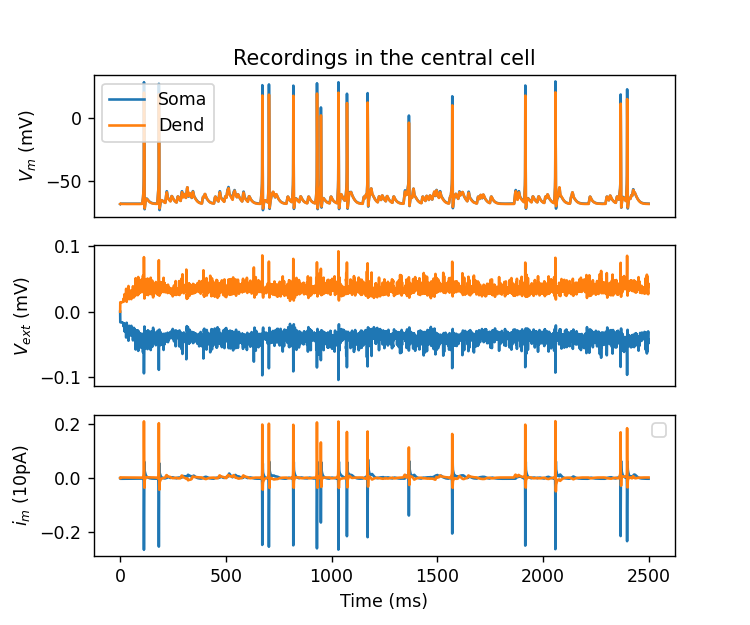

No handles with labels found to put in legend.


In [8]:
plt.figure(figsize = (6,5))
# plt.title('Recordings in the cell reciving the synapse')

plt.subplot(311)
plt.plot(time, record_intra[ncell//2][ncell//2+1], label='Soma')
plt.plot(time, record_intra_dend[ncell//2][ncell//2+1], label='Dend')
# plt.xlim([100,200])
plt.title('Recordings in the central cell')
# plt.ylim([-67.8, -67.6])
plt.ylabel('$V_m$ (mV)')
plt.gca().get_xaxis().set_visible(False)
plt.legend()

plt.subplot(312)
plt.plot(time, record_extra[ncell//2][ncell//2+1])
plt.plot(time, record_extra_dend[ncell//2][ncell//2+1])
# plt.xlim([100,200])
plt.ylabel('$V_{ext}$ (mV)')
# plt.title('Extracellular potential')
plt.gca().get_xaxis().set_visible(False)



plt.subplot(313)
plt.plot(time,corr_mem_soma[ncell//2][ncell//2+1]) 
plt.plot(time,corr_mem_dend[ncell//2][ncell//2+1]) 
# plt.xlim([100,200])
# plt.ylim([-0.88,-0.79])
plt.ylabel('$i_m$ ($10$pA)')
plt.xlabel('Time (ms)')
# plt.gca().get_xaxis().set_visible(False)


# plt.subplot(414)
# plt.eventplot(spikes)
# plt.xlabel("Time(ms)")
# plt.ylabel("#neuron")
# plt.xlim([500])


# plt.title('Intracellular potential')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


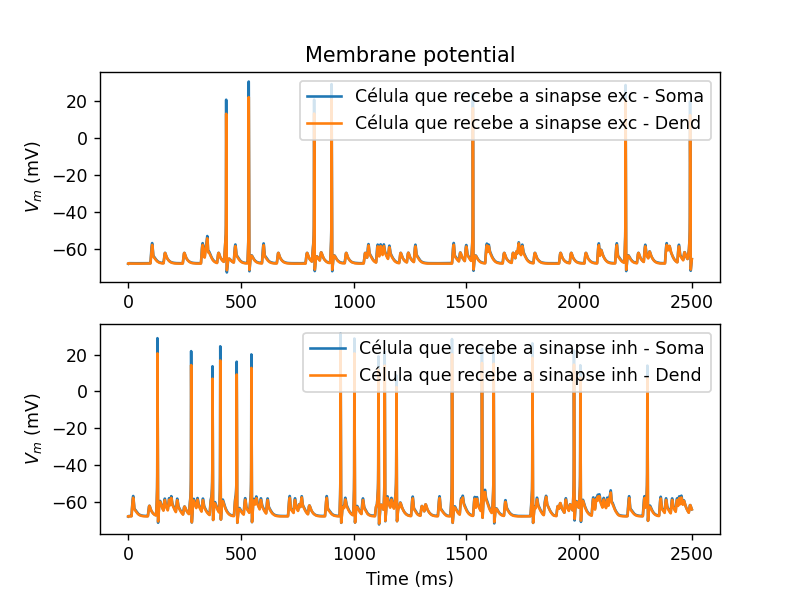

In [9]:
plt.figure()
plt.subplot(211)
plt.plot(time, record_intra[ncell//2][ncell//2], label='Célula que recebe a sinapse exc - Soma')
plt.plot(time, record_intra_dend[ncell//2][ncell//2], label='Célula que recebe a sinapse exc - Dend')
# plt.plot(time, record_intra[2][2]-record_extra[2][2], label='Soma [2][2]')
# plt.xlim([20,100])
# plt.xlim([110,200])
plt.title('Membrane potential')
plt.ylabel('$V_m$ (mV)')
plt.legend()

plt.subplot(212)
plt.plot(time, record_intra[ncell//2+1][ncell//2+2], label='Célula que recebe a sinapse inh - Soma')
plt.plot(time, record_intra_dend[ncell//2+1][ncell//2+2], label='Célula que recebe a sinapse inh - Dend')
# plt.xlim([20,100])
# plt.xlim([110,200])

plt.ylabel('$V_m$ (mV)')
plt.xlabel('Time (ms)')

# plt.title('Membrane potential')
plt.legend()



# plt.ylim([-67.8,-67.7])
plt.ylabel('$V_m$ (mV)')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


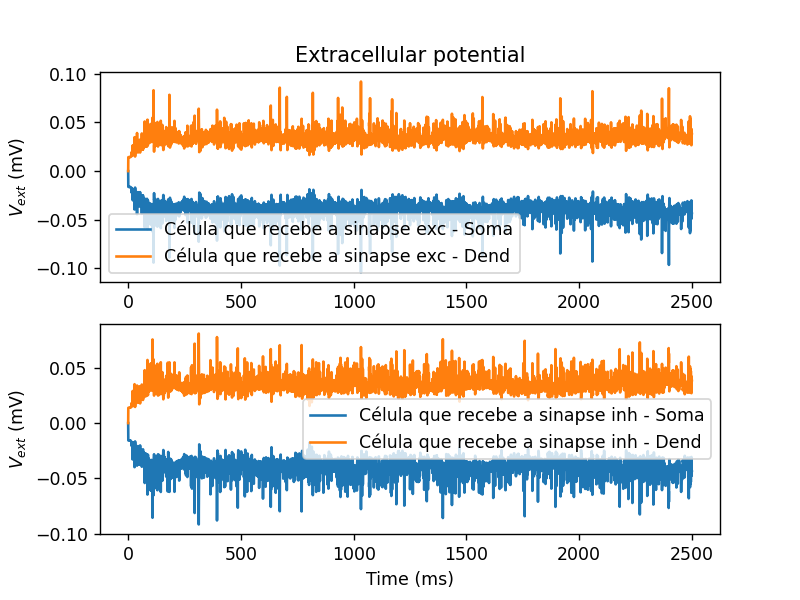

In [10]:
plt.figure()
plt.subplot(211)
plt.plot(time, record_extra[ncell//2][ncell//2+1], label='Célula que recebe a sinapse exc - Soma')
plt.plot(time, record_extra_dend[ncell//2][ncell//2+1], label='Célula que recebe a sinapse exc - Dend')
# plt.xlim([110,200])
# plt.xlim([20,100])
plt.ylabel('$V_{ext}$ (mV)')
plt.title('Extracellular potential')
plt.legend()

plt.subplot(212)
plt.plot(time, record_extra[ncell//2][ncell//2+2], label='Célula que recebe a sinapse inh - Soma')
plt.plot(time, record_extra_dend[ncell//2][ncell//2+2], label='Célula que recebe a sinapse inh - Dend')
# plt.xlim([20,100])
# plt.xlim([110,200])

# plt.ylim([-67.8,-67.7])
plt.ylabel('$V_{ext}$ (mV)')
plt.xlabel('Time (ms)')
# plt.title('Intracellular potential')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


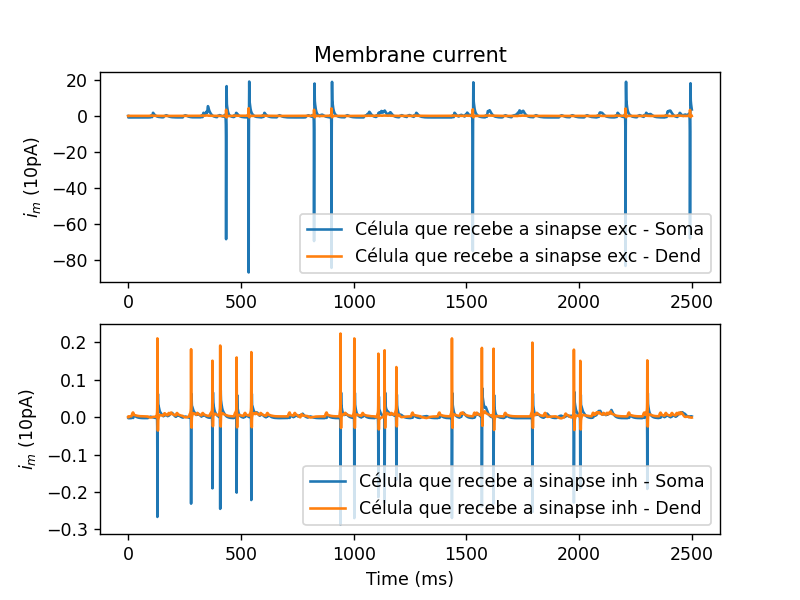

In [11]:
plt.figure()
plt.subplot(211)
plt.plot(time, corr_mem_soma[ncell//2][ncell//2], label='Célula que recebe a sinapse exc - Soma')
plt.plot(time, corr_mem_dend[ncell//2][ncell//2], label='Célula que recebe a sinapse exc - Dend')
# plt.xlim([110,200])
plt.ylabel('$i_m$ (10pA)')
plt.title('Membrane current')
plt.legend()

plt.subplot(212)
# plt.plot(time, corr_syn[0])
plt.plot(time, corr_mem_soma[ncell//2+1][ncell//2+2], label='Célula que recebe a sinapse inh - Soma')
plt.plot(time, corr_mem_dend[ncell//2+1][ncell//2+2], label='Célula que recebe a sinapse inh - Dend')
# plt.xlim([110,200])
# plt.ylim([-1.1,-0.75])
plt.ylabel('$i_m$ (10pA)')
plt.xlabel('Time (ms)')
# plt.title('Intracellular potential')
plt.legend()
plt.show()

In [12]:
# plt.figure()
# for vm in vm_seed:
#     plt.plot(time, vm)

In [13]:
#Qual que é esta celula?
print(ncell//2)
cellnumber = 50
ii = cellnumber//(ncell)
jj = cellnumber%(ncell)
print("i={},j={}".format(ii,jj))
cellindex = [ncell//2,ncell//2]
print('cellnumber = {}'.format(ncell*cellindex[0]+cellindex[1]))

8
i=2,j=16
cellnumber = 144


aqui vale notar que vaos ter uma frequencia media de 15ms entre os spikes.


In [14]:
# plt.figure(figsize = (8,3.5))
# plt.title("Comportamento com diferentes vizinhanças")

# plt.subplot(221)
# plt.plot(np.arange(neigh+1), immax)
# # plt.plot(np.linspace(0, delaymax, num=50), immax)
# plt.ylabel("$i_m$max($10$pA)")
# plt.xlabel("Delay (ms)")

# plt.subplot(222)
# plt.plot(np.arange(neigh+1), immin)
# # plt.plot(np.linspace(0, delaymax, num=50), immin)
# plt.ylabel("$i_m$min($10$pA)")
# plt.xlabel("Delay (ms)")

# plt.subplot(223)
# plt.plot(np.arange(neigh+1), vmmax)
# # plt.plot(np.linspace(0, delaymax, num=50), vmmax)
# plt.ylabel("$V_m$max(mV)")
# plt.xlabel("Delay (ms)")

# plt.subplot(224)
# plt.plot(np.arange(neigh+1), vextmin)
# # plt.plot(np.linspace(0, delaymax, num=50), vextmin)
# plt.ylabel("$V_{ext}$min(mV)")
# plt.xlabel("Delay (ms)")
# # plt.legend()
# plt.show()

In [15]:
# plt.figure()
# # f, pxx = periodogram(calculo_LFP.V_mem[1:], fs)
# # plt.plot(f[1:101],pxx[1:101])
# f, pxx = periodogram(calculo_LFP.LFP[1:], fs)
# plt.plot(f[:101],1000*pxx[:101],label="LFP")
# f, pxx = periodogram(record_extra[2][2][1:], fs)
# plt.plot(f[:101],1000*pxx[:101],label="soma#12")
# f, pxx = periodogram(record_extra[2][3][1:], fs)
# plt.plot(f[:101],1000*pxx[:101],label="soma#13")
# plt.title("Extracelular potentials periodogram")
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("Power ($10^{-3}$dB)")
# plt.legend()


<IPython.core.display.Javascript object>


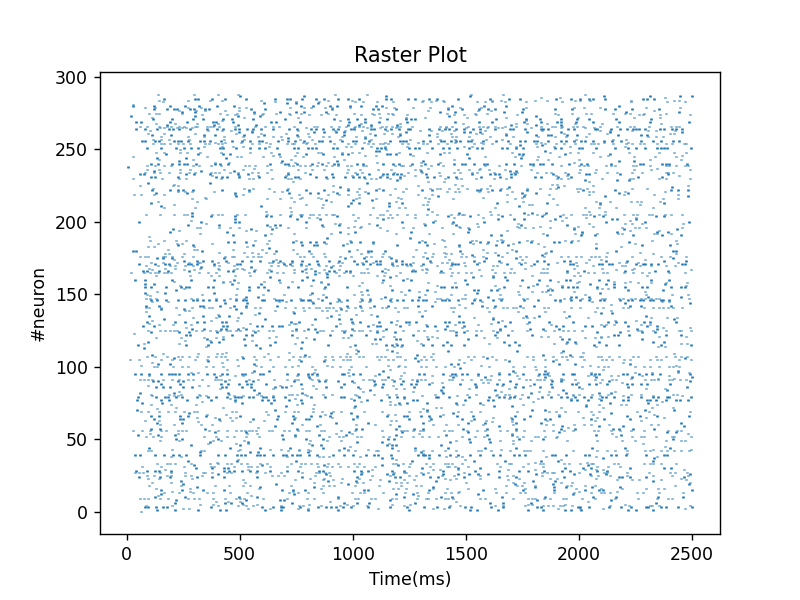

Text(0.5, 1.0, 'Raster Plot')

In [16]:
plt.figure()
plt.eventplot(spikes)
plt.xlabel("Time(ms)")
plt.ylabel("#neuron")
plt.title("Raster Plot")

### saida de dados

In [17]:
    ##### EXPORT DATA
# mean = np.mean(vext_exp, axis=0)
# std = np.std(vext_exp, axis=0)

# record_extra_dend[ncell//2][ncell//2+1].tofile('Vext(mV)-OneStrongSyn-Dend.csv', sep=',')
# record_extra[ncell//2][ncell//2+1].tofile('Vext(mV)-OneStrongSyn-Soma.csv', sep=',')

# mean = np.mean(vm_exp, axis=0)
# std = np.std(vm_exp, axis=0)
# for vmemb in vm:
# vm_soma = record_intra[ncell//2][ncell//2+1]-record_extra[ncell//2][ncell//2+1]
# vm_dend = record_intra_dend[ncell//2][ncell//2+1]-record_extra_dend[ncell//2][ncell//2+1]
# vm_soma.tofile('Vm(mV)-OneStrongSyn-Soma.csv', sep=',')
# vm_dend.tofile('Vm(mV)-OneStrongSyn-Dend.csv', sep=',')
    
# mean = np.mean(im_exp, axis=0)
# std = np.std(im_exp, axis=0)
# for im in corr_mem_soma[ncell//2][ncell//2]:
# corr_mem_soma[ncell//2][ncell//2+1].tofile('im(10pA)-OneStrongSyn-Soma.csv', sep=',')
# corr_mem_dend[ncell//2][ncell//2+1].tofile('im(10pA)-OneStrongSyn-Dend.csv', sep=',')

# ieph = (record_extra[ncell//2][ncell//2+1] - record_extra_dend[ncell//2][ncell//2+1]) / (xraxial_soma*(diam_soma/2) + xraxail_dend*(L_dend/2))
# ieph.tofile('im(10pA)-OneStrongSyn-iephaptic-Dend2Soma.csv', sep=',')

#######################################
# os.chdir(r'C:\Users\angel\OneDrive\Área de Trabalho\reyesdelrey\Dados\Network80-20SinkSource')

# time.tofile('time.csv', sep=',') 

# for i,spk in enumerate(spikes): 
#         spk.tofile('spikes(ms)-Network80-20-cell{}.csv'.format(i), sep=',')

# for i,__ in enumerate(record_extra):
#         for j, vext in enumerate(__):
#                 vext.tofile('Vext(mV)-Network80-20,Cell[{}][{}]-Soma.csv'.format(i,j), sep=',')
# for i,__ in enumerate(record_extra_dend):
#         for j, vext in enumerate(__):
#                 vext.tofile('Vext(mV)-Network80-20,Cell[{}][{}]-Dend.csv'.format(i,j), sep=',')
                
# for i,__ in enumerate(record_intra):
#         for j, vext in enumerate(__):
#                 vext.tofile('Vm(mV)-Network80-20,Cell[{}][{}]-Soma.csv'.format(i,j), sep=',')
# for i,__ in enumerate(record_intra_dend):
#         for j, vext in enumerate(__):
#                 vext.tofile('Vm(mV)-Network80-20,Cell[{}][{}]-Dend.csv'.format(i,j), sep=',')
                
# for i,__ in enumerate(corr_mem_soma):
#         for j, vext in enumerate(__):
#                 vext.tofile('im(10pA)-Network80-20,Cell[{}][{}]-Soma.csv'.format(i,j), sep=',')
# for i,__ in enumerate(corr_mem_dend):
#         for j, vext in enumerate(__):
#                 vext.tofile('im(10pA)-Network80-20,Cell[{}][{}]-Dend.csv'.format(i,j), sep=',')                

# testes

In [18]:
# syn_i_dend = corr_syn[0]*10**(-6)#transforma de nA para mA
# r_syn_dend = np.linalg.norm(np.array([60,125,150])-np.array([60,127.5,150]))
# LFP = -syn_i_dend /(4*h.PI*sigma*r_syn_dend*10**(-6))

# l_soma = np.linalg.norm(np.array([0,125,150])-np.array([60,127.5,150]))
# h_soma = np.linalg.norm(np.array([20,125,150])-np.array([60,127.5,150]))
# l_dend = np.linalg.norm(np.array([20,125,150])-np.array([60,127.5,150]))
# h_dend = np.linalg.norm(np.array([120,125,150])-np.array([60,127.5,150]))
# Vout_soma = ((corr_mem_soma[ncell//2][ncell//2+1]*(diam_soma*10**(-4)/2))/(2*sigma*10**(-2)))*math.log(((h_soma**2+(diam_soma/2)**2)**0.5-h_soma)/((l_soma**2+(diam_soma/2)**2)**0.5-l_soma))
# Vout_dend = ((corr_mem_dend[ncell//2][ncell//2+1]*(diam_dend*10**(-4)/2))/(2*sigma*10**(-2)))*math.log(((h_dend**2+(diam_dend/2)**2)**0.5-h_dend)/((l_dend**2+(diam_dend/2)**2)**0.5-l_dend))
# LFP += Vout_soma + Vout_dend

# l_soma = np.linalg.norm(np.array([0,125,125])-np.array([60,127.5,150]))
# h_soma = np.linalg.norm(np.array([20,125,125])-np.array([60,127.5,150]))
# l_dend = np.linalg.norm(np.array([20,125,125])-np.array([60,127.5,150]))
# h_dend = np.linalg.norm(np.array([120,125,125])-np.array([60,127.5,150]))
# Vout_soma = ((corr_mem_soma[ncell//2][ncell//2]*(diam_soma*10**(-4)/2))/(2*sigma*10**(-2)))*math.log(((h_soma**2+(diam_soma/2)**2)**0.5-h_soma)/((l_soma**2+(diam_soma/2)**2)**0.5-l_soma))
# Vout_dend = ((corr_mem_dend[ncell//2][ncell//2]*(diam_dend*10**(-4)/2))/(2*sigma*10**(-2)))*math.log(((h_dend**2+(diam_dend/2)**2)**0.5-h_dend)/((l_dend**2+(diam_dend/2)**2)**0.5-l_dend))
# LFP += Vout_soma + Vout_dend

# plt.figure()
# plt.plot(time,LFP)



In [19]:
# h.PlotShape(False).plot(plt)
# plt.xlabel('x')
# plt.ylabel('z')

In [20]:
# syn_i_soma = corr_syn[0]*10**(-6)#transforma de nA para mA
# r_syn_soma = np.linalg.norm(np.array([60,125,150])-np.array([10,135,150]))
# LFP = -syn_i_soma /(4*h.PI*sigma*r_syn_soma*10**(-6))

# l_soma = np.linalg.norm(np.array([0,125,150])-np.array([10,135,150]))
# h_soma = np.linalg.norm(np.array([20,125,150])-np.array([10,135,150]))
# l_dend = np.linalg.norm(np.array([20,125,150])-np.array([10,135,150]))
# h_dend = np.linalg.norm(np.array([120,125,150])-np.array([10,135,150]))
# Vout_soma = ((corr_mem_soma[ncell//2][ncell//2+1]*(diam_soma*10**(-4)/2))/(2*sigma*10**(-2)))*math.log(((h_soma**2+(diam_soma/2)**2)**0.5-h_soma)/((l_soma**2+(diam_soma/2)**2)**0.5-l_soma))
# Vout_dend = ((corr_mem_dend[ncell//2][ncell//2+1]*(diam_dend*10**(-4)/2))/(2*sigma*10**(-2)))*math.log(((h_dend**2+(diam_dend/2)**2)**0.5-h_dend)/((l_dend**2+(diam_dend/2)**2)**0.5-l_dend))
# LFP += Vout_soma + Vout_dend

# l_soma = np.linalg.norm(np.array([0,125,125])-np.array([10,135,150]))
# h_soma = np.linalg.norm(np.array([20,125,125])-np.array([10,135,150]))
# l_dend = np.linalg.norm(np.array([20,125,125])-np.array([10,135,150]))
# h_dend = np.linalg.norm(np.array([120,125,125])-np.array([10,135,150]))
# Vout_soma = ((corr_mem_soma[ncell//2][ncell//2]*(diam_soma*10**(-4)/2))/(2*sigma*10**(-2)))*math.log(((h_soma**2+(diam_soma/2)**2)**0.5-h_soma)/((l_soma**2+(diam_soma/2)**2)**0.5-l_soma))
# Vout_dend = ((corr_mem_dend[ncell//2][ncell//2]*(diam_dend*10**(-4)/2))/(2*sigma*10**(-2)))*math.log(((h_dend**2+(diam_dend/2)**2)**0.5-h_dend)/((l_dend**2+(diam_dend/2)**2)**0.5-l_dend))
# LFP += Vout_soma + Vout_dend

# plt.figure()
# plt.plot(time,LFP)

<IPython.core.display.Javascript object>


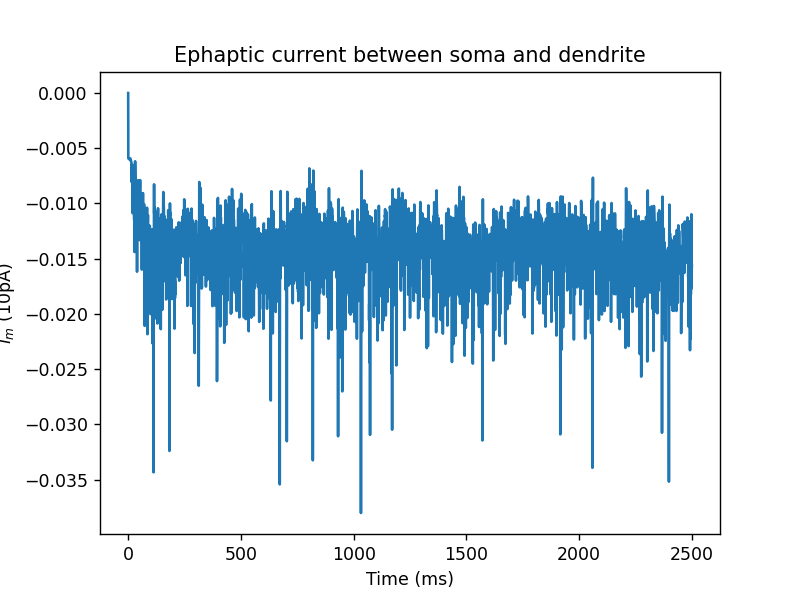

' soma-dend: corrente saindo do e dend e indo para o soma.'

In [21]:
ieph = (record_extra[ncell//2][ncell//2+1] - record_extra_dend[ncell//2][ncell//2+1]) / (xraxial_soma*(10**(-4))*(diam_soma/2) + xraxail_dend*(10**(-4))*(L_dend/2))
plt.figure()
plt.plot(time,ieph)
plt.title('Ephaptic current between soma and dendrite')
# plt.xlim([110,150])
plt.ylabel('$i_m$ (10pA)')
plt.xlabel('Time (ms)')
""" soma-dend: corrente saindo do e dend e indo para o soma."""

In [22]:
for _ in range(1,6, 1):
    print(_)

1
2
3
4
5


In [23]:
ncell

17

In [24]:
len(sinapse)

867

In [25]:
# feather.write_dataframe(ff, 'LFP_data.feather')
# ff.to_feather('LFP_data.feather')
# CODIGO NICOLAS

# excit_excit_prob = 0.05
# excit_inhib_prob = 0.05
# inhib_excit_prob = 0.05

In [26]:
# def estim_poisson_fixados():
    